<a href="https://colab.research.google.com/github/Rachel-0420/TLM-Continuous-Data/blob/main/Example_TLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TheLastMetric end-to-end

_Alex Malz (CMU), Bryan Scott (Northwestern), François Lanusse (CEA), John Franklin Crenshaw (UW), Melissa Graham (UW)_

In [5]:
# install required libraries

!pip install --upgrade "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install astropy pzflow corner

Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html


This cell imports all of the dependencies for training and working with normalizing flows

In [6]:
# import statements

from pzflow import Flow
import jax.numpy as jnp
import pandas as pd
import numpy as np
import pickle
import corner
import matplotlib.pyplot as plt
import os
from astropy.table import Table
from pzflow import Flow, FlowEnsemble
from pzflow.distributions import Uniform
from pzflow.bijectors import Chain, StandardScaler, NeuralSplineCoupling, ColorTransform, InvSoftplus, RollingSplineCoupling, ShiftBounds
from collections import namedtuple

import scipy.stats as sps

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
prepend = '/content/drive/MyDrive/'
input_data_dir = '/content/drive/MyDrive/TLMdata/'
data_dir = '/content/drive/MyDrive/'

This cell opens a readme file containing the mapping between simulation runids and observing strategy names.

In [9]:
all_readme = open(os.path.join(input_data_dir,'readme.txt')).read().split('\n')

print(type(all_readme))

# visualize data
data_tables = ""
for line in all_readme:
  data_tables += line
  if line != all_readme[-1]:
    data_tables += "\n"
print(data_tables)

<class 'list'>
runid      OpSim Name                           ugrizy 5sigma depths
1_4_y10    baseline_v1_5_10yrs                  25.86 27.02 26.99 26.42 25.70 24.94
4_38_y10   footprint_stuck_rollingv1_5_10yrs    25.56 26.68 26.62 26.06 25.33 24.61
10_92_y10  ddf_heavy_nexp2_v1_6_10yrs           25.57 26.82 26.84 26.26 25.57 24.82
4_34_y10   footprint_newAv1_5_10yrs             25.75 26.87 26.85 26.29 25.55 24.78
7_61_y10   third_obs_pt60v1_5_10yrs             25.87 27.03 26.99 26.43 25.70 24.93
9_86_y10   barebones_v1_6_10yrs                 26.00 27.13 27.07 26.57 25.78 25.05

test.cat contains the simulated observed apparent magnitudes
0     : identifier
1     : true redshift
2,3   : u, u uncertainty
4,5   : g, g uncertainty
6,7   : r, r uncertainty
8,9   : i, i uncertainty
10,11 : z, z uncertainty
12,13 : y, y uncertainty
14,15 : u-g, u-g uncertainty
16,17 : g-r, g-r uncertainty
18,19 : r-i, r-i uncertainty
20,21 : i-z, i-z uncertainty
22,23 : z-y, z-y uncertainty

zphot.cat con

In [10]:
# individual columns basing on OS

print(all_readme[1].index('25.86')) # is 48

data_tableMain = []
for lineNum in range(1,7):
  line = all_readme[lineNum]
  data_tableMain += [line[48:].split( )]
for row in range(len(data_tableMain)):
  for col in range(len(data_tableMain[0])):
    data_tableMain[row][col] = float(data_tableMain[row][col])

# individual columns basing on filter

data_filters = []
for col in range(6):
  line = []
  for row in range(len(data_tableMain)):
    line.append(float(data_tableMain[row][col]))
  data_filters.append(line)

#discrete case

data_i = data_filters[3]
for ind in range(len(data_i)):
  data_i[ind] = float(data_i[ind])
  data_i[ind] = round(data_i[ind])

data_filtersWithRounded = data_filters + [data_i]

48


In [11]:
## Model of bar Graph for all filters

#filters = ['u', 'g', 'r', 'i', 'z', 'y']
#matching = {'u':data_filters[0], 'g':data_filters[1], 'r':data_filters[2], 'i':data_filters[3], 'z':data_filters[4], 'y':data_filters[5]}
#for ind in range(len(filters)):
#  current_filter = filters[ind]
#  x = matching.get(current_filter)
#  y = [1,2,3,4,5,6]
#  plt.ylabel('Trial')
#  plt.ylabel('Data')
#  plt.title("Graph for " + current_filter)
#  plt.bar(y, x, width=0.4)
#  plt.show()


In [12]:
in_metadata = []

colors = ["k", "plum", "cornflowerblue", "#2ca02c", "gold", "tomato"]

for i, line in enumerate(all_readme[0:6]):
  descr = all_readme[i+1].split()
  in_metadata.append(descr)
  # same as the data_tableMain in the above code box

  metadatum = namedtuple('metadatum', ['runid', 'OpSimName', 'u', 'g', 'r', 'i', 'z', 'y'])

  metadata = {}
  for row in in_metadata:
    metadata[row[0]] = metadatum(*row)
  # makes a dictionary for the data

  names_z=('ID', 'z_true', 'z_phot', 'dz_phot', 'NN', 'N_train')
  names_phot=('ID', 'z_true',
    'u', 'err_u', 'g', 'err_g', 'r', 'err_r', 'i', 'err_i', 'z', 'err_z', 'y', 'err_y',
    'u-g', 'err_u-g', 'g-r', 'err_g-r', 'r-i', 'err_r-i', 'i-z', 'err_i-z', 'z-y', 'err_z-y')

  available_os = list(metadata.keys())
  names = [metadata[runid].OpSimName for runid in available_os]
  os_names = dict(zip(available_os, names))
  os_colors = dict(zip(available_os, colors))
print(os_names)
print(os_colors)

{'1_4_y10': 'baseline_v1_5_10yrs', '4_38_y10': 'footprint_stuck_rollingv1_5_10yrs', '10_92_y10': 'ddf_heavy_nexp2_v1_6_10yrs', '4_34_y10': 'footprint_newAv1_5_10yrs', '7_61_y10': 'third_obs_pt60v1_5_10yrs', '9_86_y10': 'barebones_v1_6_10yrs'}
{'1_4_y10': 'k', '4_38_y10': 'plum', '10_92_y10': 'cornflowerblue', '4_34_y10': '#2ca02c', '7_61_y10': 'gold', '9_86_y10': 'tomato'}


Confirm the correct file was read and that the mapping from runid to observing strategy name is as expected.

In [13]:
print(available_os)
print(names)

['1_4_y10', '4_38_y10', '10_92_y10', '4_34_y10', '7_61_y10', '9_86_y10']
['baseline_v1_5_10yrs', 'footprint_stuck_rollingv1_5_10yrs', 'ddf_heavy_nexp2_v1_6_10yrs', 'footprint_newAv1_5_10yrs', 'third_obs_pt60v1_5_10yrs', 'barebones_v1_6_10yrs']


Define tuples for the redshift and photometric column names in the simulation catalogs.

In [14]:
names_z=('ID', 'z_true', 'z_phot', 'dz_phot', 'NN', 'N_train')
names_phot=('ID', 'z_true',
        'u', 'g', 'r', 'i', 'z', 'y',
        'err_u', 'err_g', 'err_r', 'err_i', 'err_z', 'err_y',
        'u-g', 'g-r', 'r-i', 'i-z', 'z-y',
        'err_u-g', 'err_g-r', 'err_r-i', 'err_i-z', 'err_z-y')


#available_os = ['baseline_v1.4_10yrs', 'twilight_neo_mod1_v1.4_10yrs', 'var_expt_v1.4_10yrs', 'weather_1.2_v1.4_10yrs']
#os_colors = {'baseline_v1.4_10yrs': 'k', 'twilight_neo_mod1_v1.4_10yrs': '#2ca02c', 'var_expt_v1.4_10yrs': '#1f77b4', 'weather_1.2_v1.4_10yrs': '#ff7f0e'}



Now, read in the photometry and redshift catalogs. Define dictionaries that map the catalogs to the observing strategies.

In [15]:
phot_cats, z_cats = {}, {}

for name, which_os in zip(names, available_os):
  test_cat = Table.read(input_data_dir+'run_'+which_os+'/test.cat', format='ascii')
  z_cat = Table.read(input_data_dir+'run_'+which_os+'/zphot.cat',
                       format='ascii',
                       names=names_z)
  phot_cat = Table.read(input_data_dir+'run_'+which_os+'/test.cat',
                       format='ascii',
                       names=names_phot)
  phot_cat = Table.from_pandas(phot_cat.to_pandas().dropna())
  phot_cats[which_os] = phot_cat
  # print('phot: ')
  z_cats[which_os] = z_cat
  # print('z: ')
  # print(len(z_cats[which_os]))

In [16]:
print(type(phot_cats))
print(type(phot_cats[available_os[0]]))

<class 'dict'>
<class 'astropy.table.table.Table'>


In [17]:
z_cats_no_nan = {}
for which_os in available_os:
  IDS = phot_cats[which_os]['ID']
  z_cats_no_nan[which_os] = z_cats[which_os].to_pandas()[z_cats[which_os].to_pandas()['ID'].isin(IDS)]
  print(phot_cats[which_os])

   ID      z_true       u        g     ... err_g-r  err_r-i   err_i-z  err_z-y 
-------- ---------- --------- -------- ... -------- -------- --------- --------
 3062006  0.4555725 21.055191 0.006417 ... 0.171704 0.007071  0.050152 0.007071
  453233  0.5184816 23.017587 0.020408 ... 0.090451 0.007312  0.031094 0.011781
 3478720  0.6159301 24.442744 0.062563 ... 0.096645 0.022924  0.002698 0.041638
  758503    1.07005  23.84643 0.036386 ...  0.71129 0.017555  0.151732 0.023491
13868964  1.2806728 23.731692 0.035743 ... 0.780367 0.013383  0.339147 0.014368
13423143  0.8360027 24.814279 0.077923 ... 0.449465 0.015368   0.16905 0.022784
 3833075  1.0861683 24.963398 0.086959 ... 0.691559 0.059034 -0.030134    0.091
13052158  1.7057002 24.376038 0.052586 ... 0.376872 0.020442  0.202569 0.030427
11094022 0.20821726 23.139865  0.02256 ... 0.210718 0.007071  0.085524 0.007071
 5893955  0.9978553 24.511642 0.060823 ... 0.343953 0.043772  0.062791 0.075333
     ...        ...       ...      ... .

In [18]:
# # view the photometric catalog for one observing strategy

# print(phot_cats[available_os[0]])

Visualize the input redshift distributions n(z) for each runID/observing strategy.

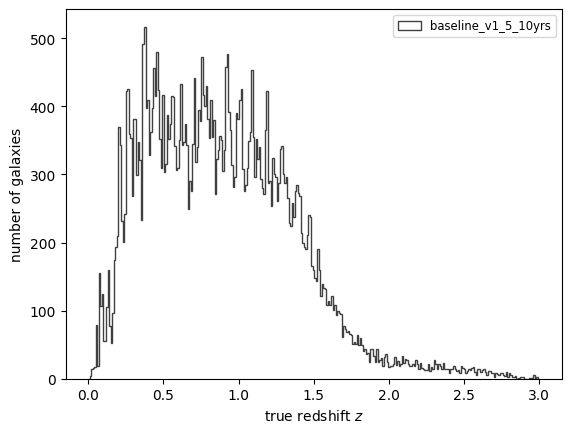

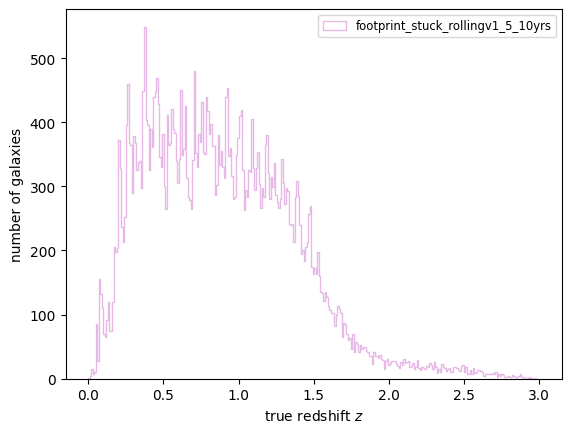

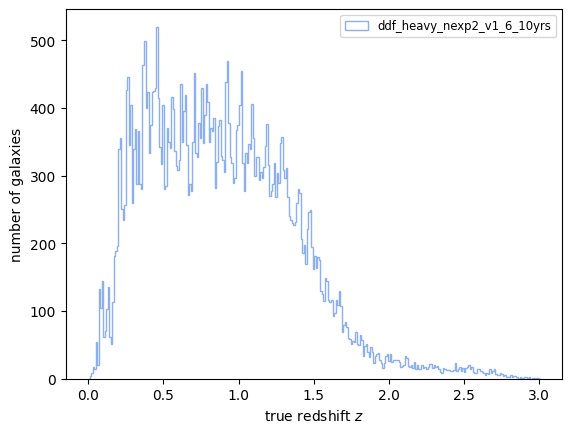

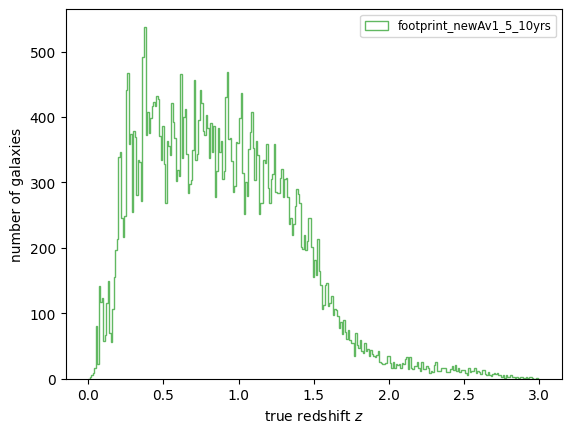

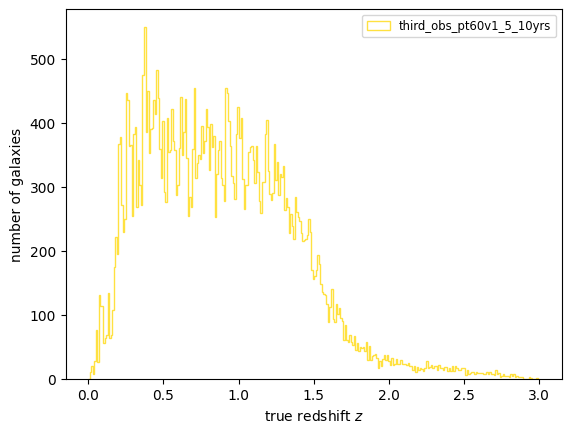

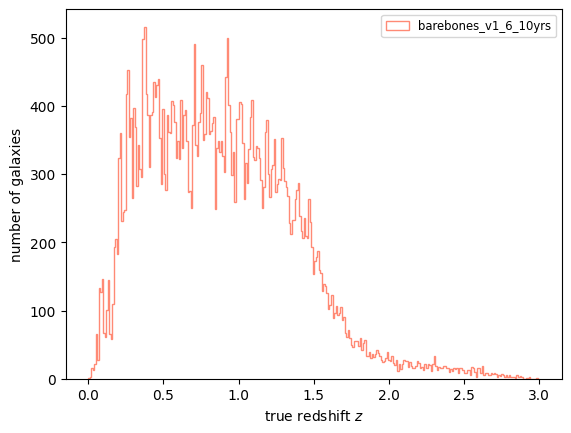

In [19]:
# Each OS individually

from matplotlib.pyplot import hist, xlabel, ylabel, legend

zbins = np.linspace(0, 3, 300)

for which_os in available_os:
  hist(z_cats[which_os]['z_true'], bins=zbins, alpha=0.75, histtype="step", color=os_colors[which_os],
  label=os_names[which_os], density = False)
  xlabel('true redshift $z$')
  ylabel('number of galaxies')
  legend(loc='upper right', fontsize='small')
  plt.show()

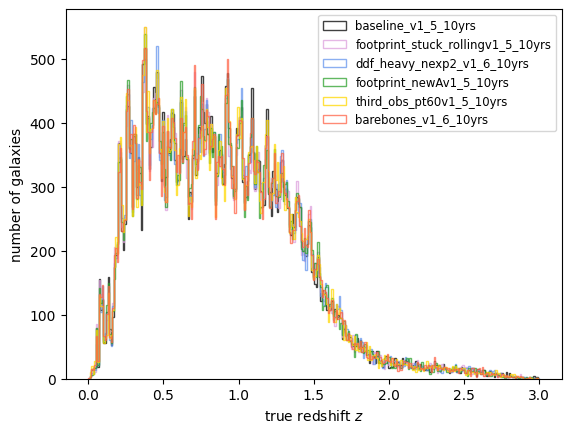

In [20]:
# All OS together

from matplotlib.pyplot import hist, xlabel, ylabel, legend

zbins = np.linspace(0, 3, 300)

for which_os in available_os:
  hist(z_cats[which_os]['z_true'], bins=zbins, alpha=0.75, histtype="step", color=os_colors[which_os],
  label=os_names[which_os], density = False)
  xlabel('true redshift $z$')
  ylabel('number of galaxies')
  legend(loc='upper right', fontsize='small')
plt.show()

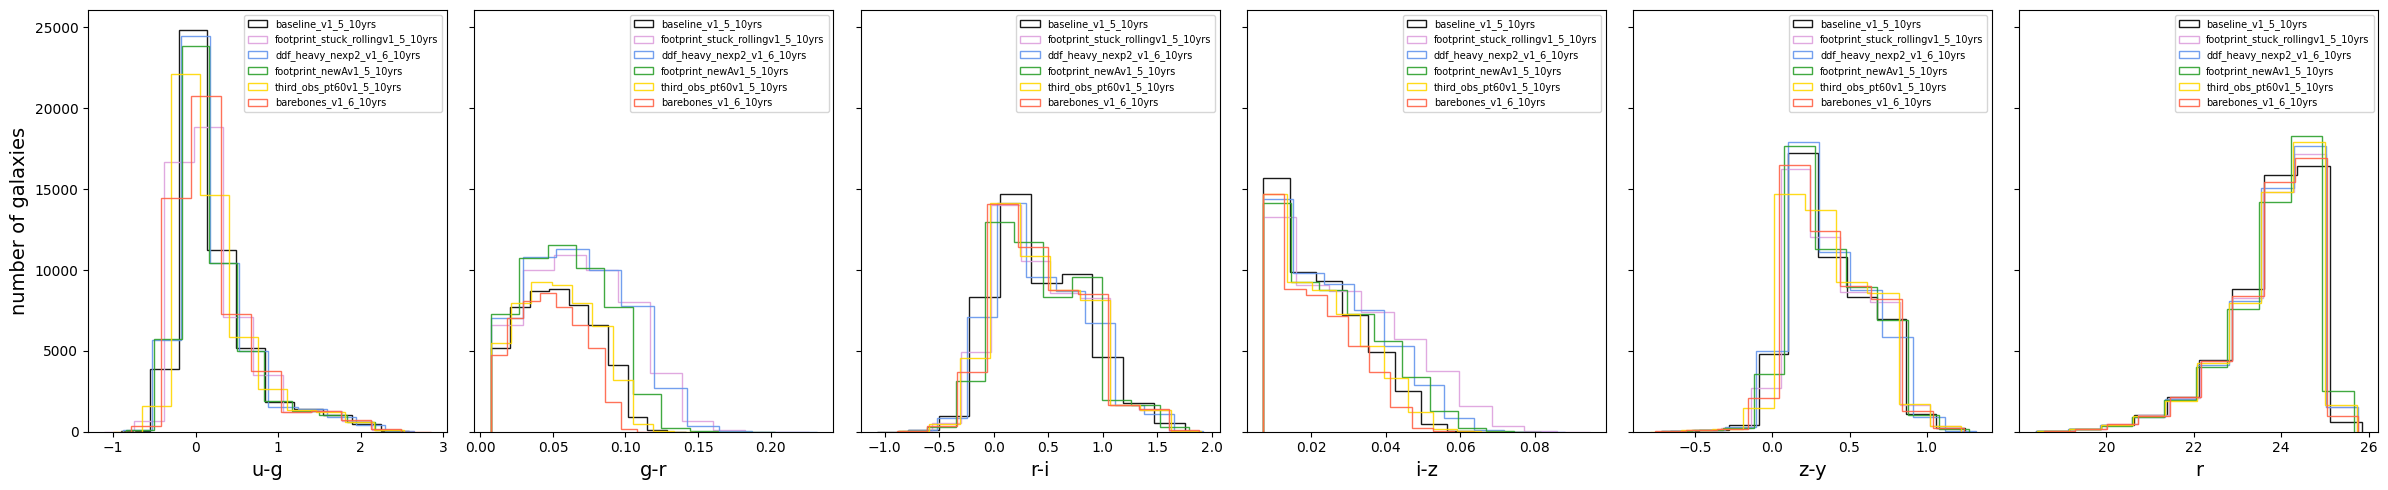

In [21]:
fig, ax = plt.subplots(1,6, figsize=(24,5), sharey=True)
for which_os in available_os:
  for b, datum in enumerate(['u-g', 'g-r', 'r-i', 'i-z', 'z-y']):
    ax[b].hist(phot_cats[which_os][datum], alpha=0.9, histtype="step", color=os_colors[which_os],
    label=os_names[which_os], density = False)
    ax[b].set_xlabel(datum, fontsize=14)
    ax[b].legend(loc='upper right', fontsize=7)
  ax[-1].hist(phot_cats[which_os]['r'], alpha=0.9, histtype="step", color=os_colors[which_os],
    label=os_names[which_os], density = False)
  ax[-1].set_xlabel('r', fontsize=14)
  ax[0].set_ylabel('number of galaxies', fontsize=14)
  ax[-1].legend(loc='upper right', fontsize=7)
plt.tight_layout()

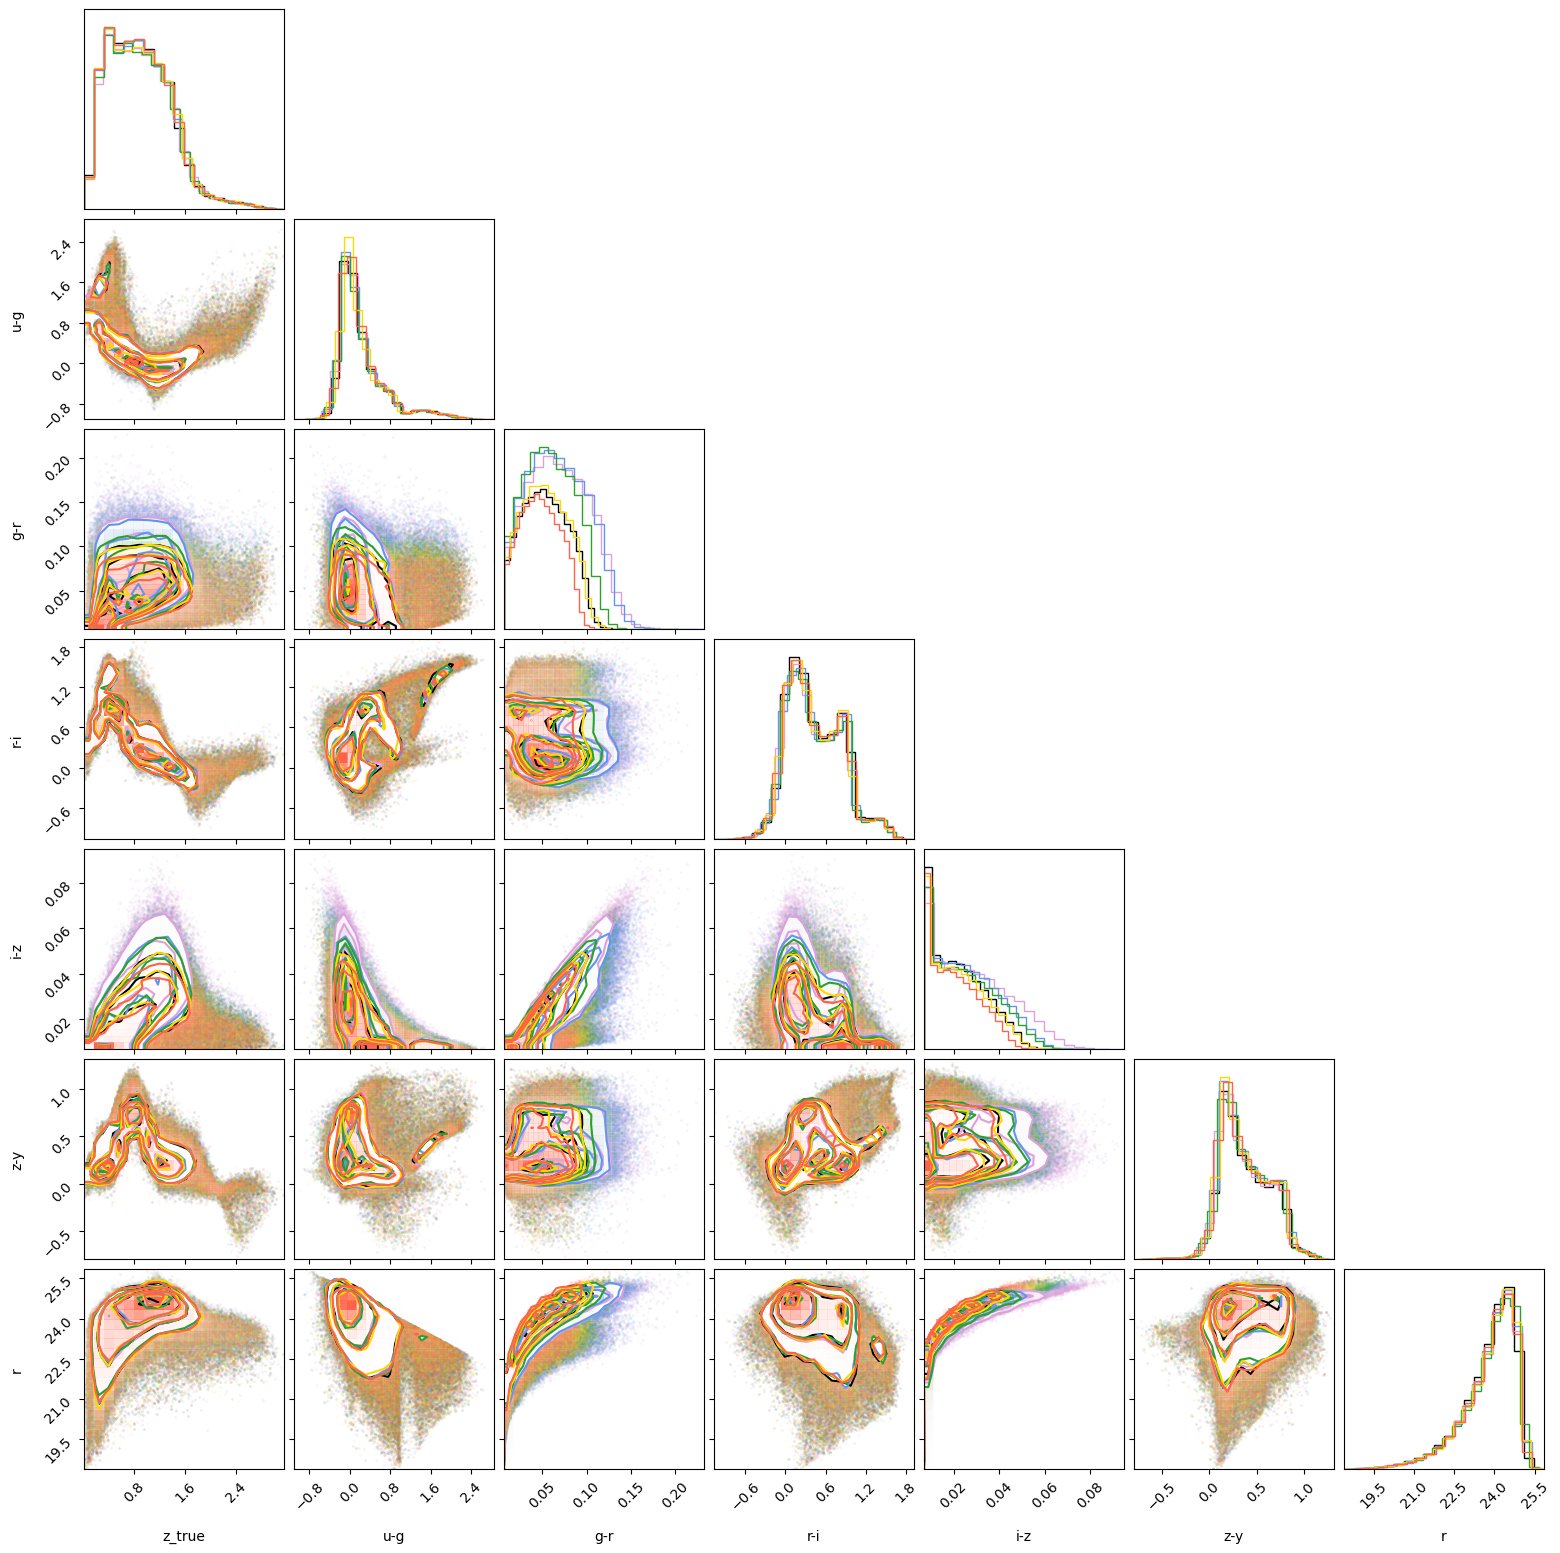

In [22]:
labels = ['z_true', 'u-g', 'g-r', 'r-i', 'i-z', 'z-y', 'r']
def prep_for_corner(one_os):
  return np.array([phot_cats[one_os]['z_true'], phot_cats[one_os]['u-g'],
                   phot_cats[one_os]['g-r'], phot_cats[one_os]['r-i'],
                   phot_cats[one_os]['i-z'], phot_cats[one_os]['z-y'],
                   phot_cats[one_os]['r']]).T
fig = corner.corner(prep_for_corner(available_os[0]), labels=labels, fontsize=14)
for which_os in available_os[1:]:
  corner.corner(prep_for_corner(which_os), fig=fig, color=os_colors[which_os], fontsize=14)

new experimentation

In [23]:
# print data in columns
# histograms of columns
# pick a column to copy (r)
# round to nearest whole number
# add a copy of it to the astropy table

In [24]:
os_interested = available_os[0]
for name in names_phot:
  print(phot_cats[os_interested][name])

   ID   
--------
 3062006
  453233
 3478720
  758503
13868964
13423143
 3833075
13052158
11094022
 5893955
     ...
13181934
 7185473
 6972324
 6773476
 3061823
13351123
 1533886
 8997230
 7822789
 1695778
 8880747
Length = 50000 rows
  z_true  
----------
 0.4555725
 0.5184816
 0.6159301
   1.07005
 1.2806728
 0.8360027
 1.0861683
 1.7057002
0.20821726
 0.9978553
       ...
0.52496433
0.71710336
 2.1423516
 0.9826621
 1.1456611
 1.5788195
 1.0775948
0.57457495
0.93646646
0.82981014
 0.8387699
Length = 50000 rows
    u    
---------
21.055191
23.017587
24.442744
 23.84643
23.731692
24.814279
24.963398
24.376038
23.139865
24.511642
      ...
24.994244
24.209463
24.947034
23.285618
24.679795
24.793853
24.211773
22.442926
24.610671
24.464735
23.260688
Length = 50000 rows
   g    
--------
0.006417
0.020408
0.062563
0.036386
0.035743
0.077923
0.086959
0.052586
 0.02256
0.060823
     ...
0.100917
0.053023
0.095621
0.023757
0.072544
0.078444
0.050367
0.013977
0.064905
0.068114
0.023352
Leng

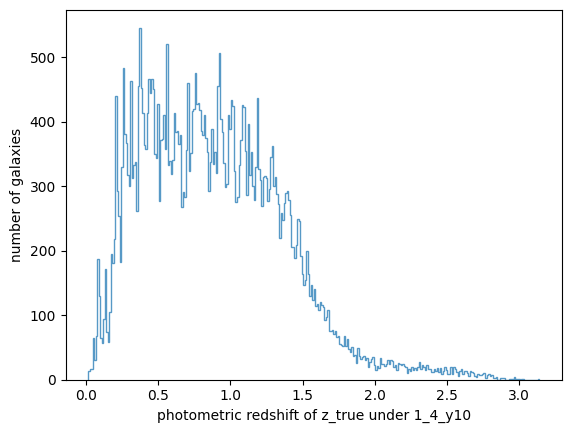

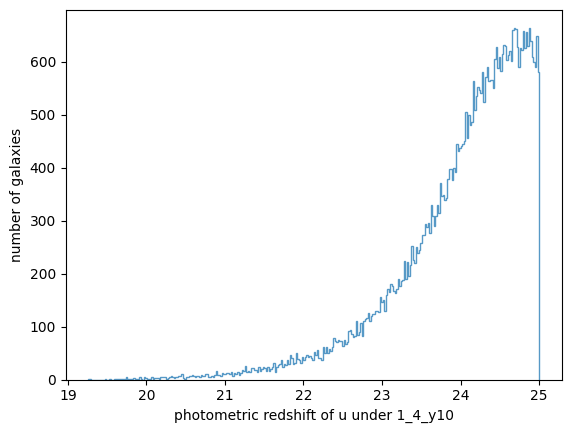

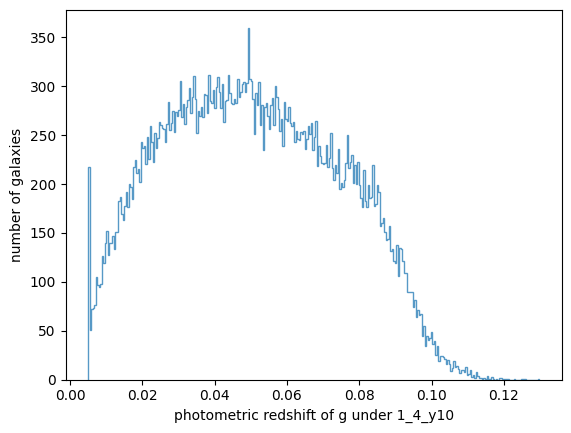

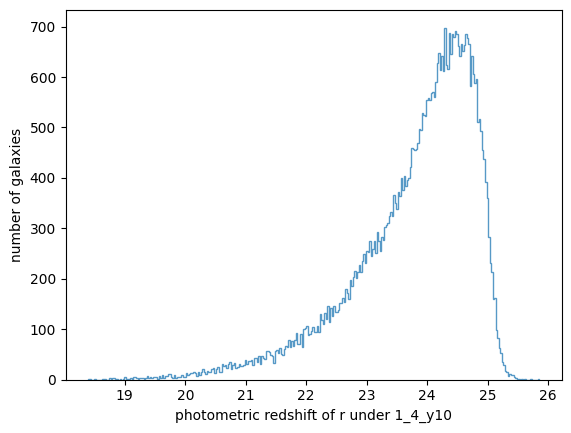

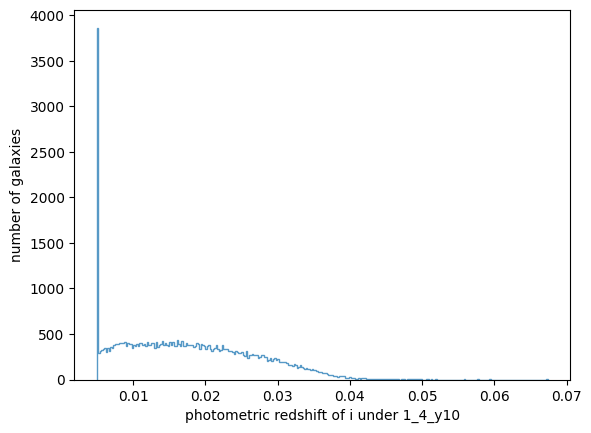

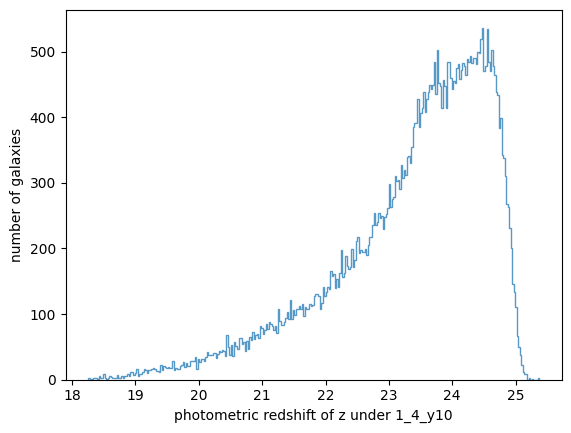

In [25]:
# Histogram of individual filters

for name in names_phot[1:7]:
  hist(phot_cats[os_interested][name], alpha=0.75, histtype="step",
  label=os_names[os_interested], density = False, bins = 300)
  xlabel('photometric redshift of ' + name + ' under ' + os_interested)
  ylabel('number of galaxies')
  plt.show()

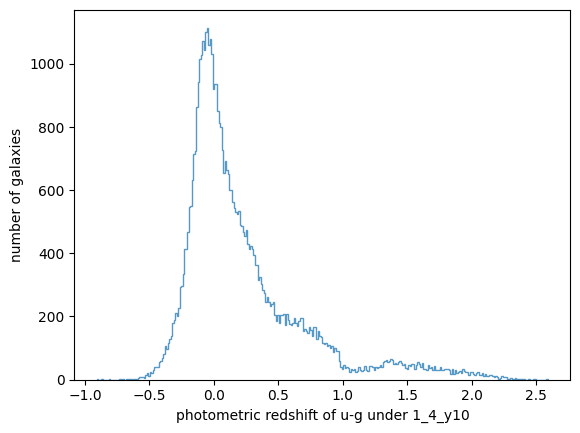

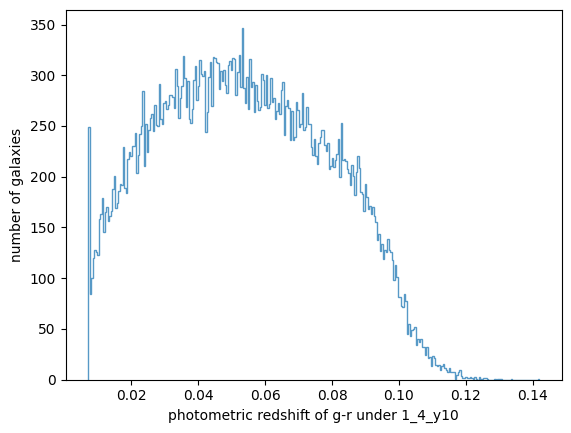

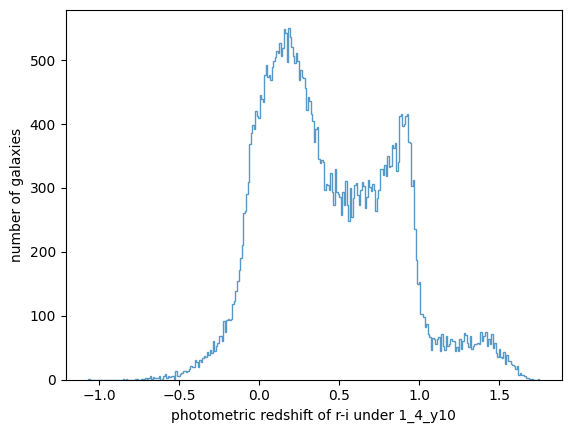

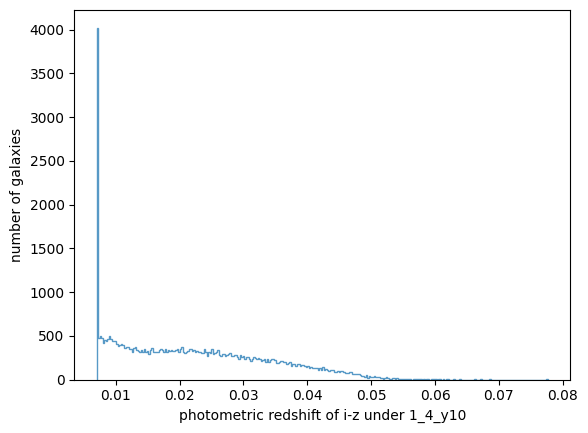

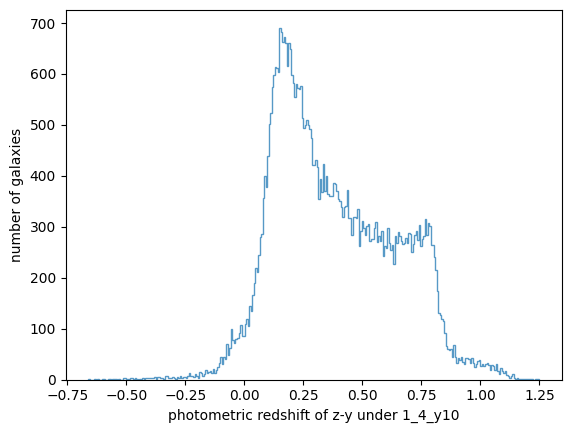

In [26]:
# Histogram of each color

for name in names_phot[14:19]:
  hist(phot_cats[os_interested][name], alpha=0.75, histtype="step",
  label=os_names[os_interested], density = False, bins = 300)
  xlabel('photometric redshift of ' + name + ' under ' + os_interested)
  ylabel('number of galaxies')
  plt.show()

In [27]:
#for which_os in available_os:
  #print(phot_cats[which_os]['r'])

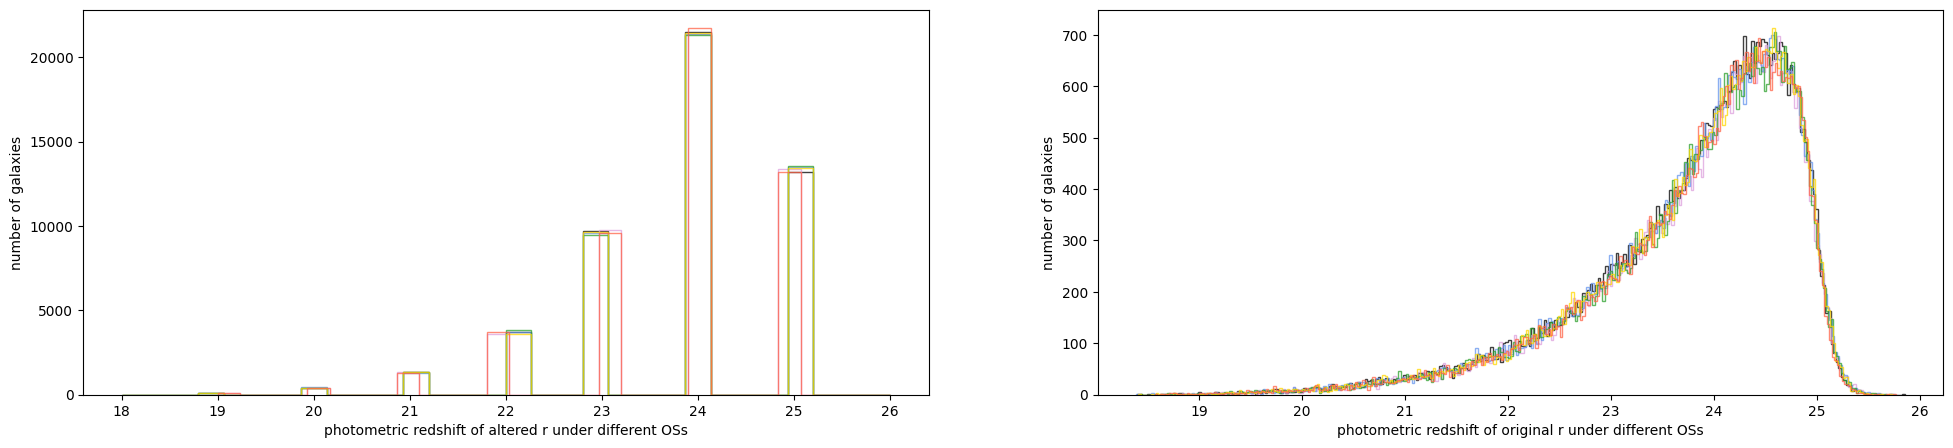

In [28]:
# Discrete case for filter r

import copy

org_cols = []
add_cols = []
for which_os in available_os:

  add_col = copy.copy(phot_cats[which_os]['r'])
  org_cols.append(phot_cats[which_os]['r'])
  for num in range(len(add_col)):
    add_col[num] = round(add_col[num])
  add_cols.append(add_col)

fig, ax = plt.subplots(1,2, figsize=(24,5), sharey=False)

for ind in range(len(add_cols)):
  ax[0].hist(add_cols[ind], alpha=0.75, histtype="step",
  label=names_phot[ind], density = False, bins=30, color=os_colors[available_os[ind]])
  ax[1].hist(org_cols[ind], alpha=0.75, histtype="step",
  label=names_phot[ind], density = False, bins=300, color=os_colors[available_os[ind]])
  ax[0].set_xlabel('photometric redshift of altered r under different OSs')
  ax[0].set_ylabel('number of galaxies')
  ax[1].set_xlabel('photometric redshift of original r under different OSs')
  ax[1].set_ylabel('number of galaxies')
plt.show()

In [29]:
# Adding rounded r data to the astropy table

for ind in range(len(available_os)):
  which_os = available_os[ind]
  phot_cats[which_os].add_column(add_cols[ind],name='r_new')
print(phot_cats[available_os[0]][0])

   ID     z_true      u        g        r       i       z       y     err_u   err_g   err_r   err_i   err_z   err_y   u-g      g-r      r-i      i-z      z-y    err_u-g  err_g-r  err_r-i  err_i-z  err_z-y  r_new
------- --------- --------- -------- -------- ----- --------- ----- --------- ----- --------- ----- --------- ----- -------- -------- -------- -------- -------- -------- -------- -------- -------- -------- -----
3062006 0.4555725 21.055191 0.006417 20.73806 0.005 19.769414 0.005 19.476623 0.005 19.304918 0.005 19.254766 0.005 0.317131 0.008135 0.968646 0.007071 0.292791 0.007071 0.171704 0.007071 0.050152 0.007071  21.0


In [30]:
for which_os in available_os:

  new_color1 = phot_cats[which_os]['g'] - phot_cats[which_os]['r_new']
  new_color2 = phot_cats[which_os]['r_new'] - phot_cats[which_os]['i']

  phot_cats[which_os].add_column(new_color1, name='g-r_new')
  phot_cats[which_os].add_column(new_color2, name='r_new-i')

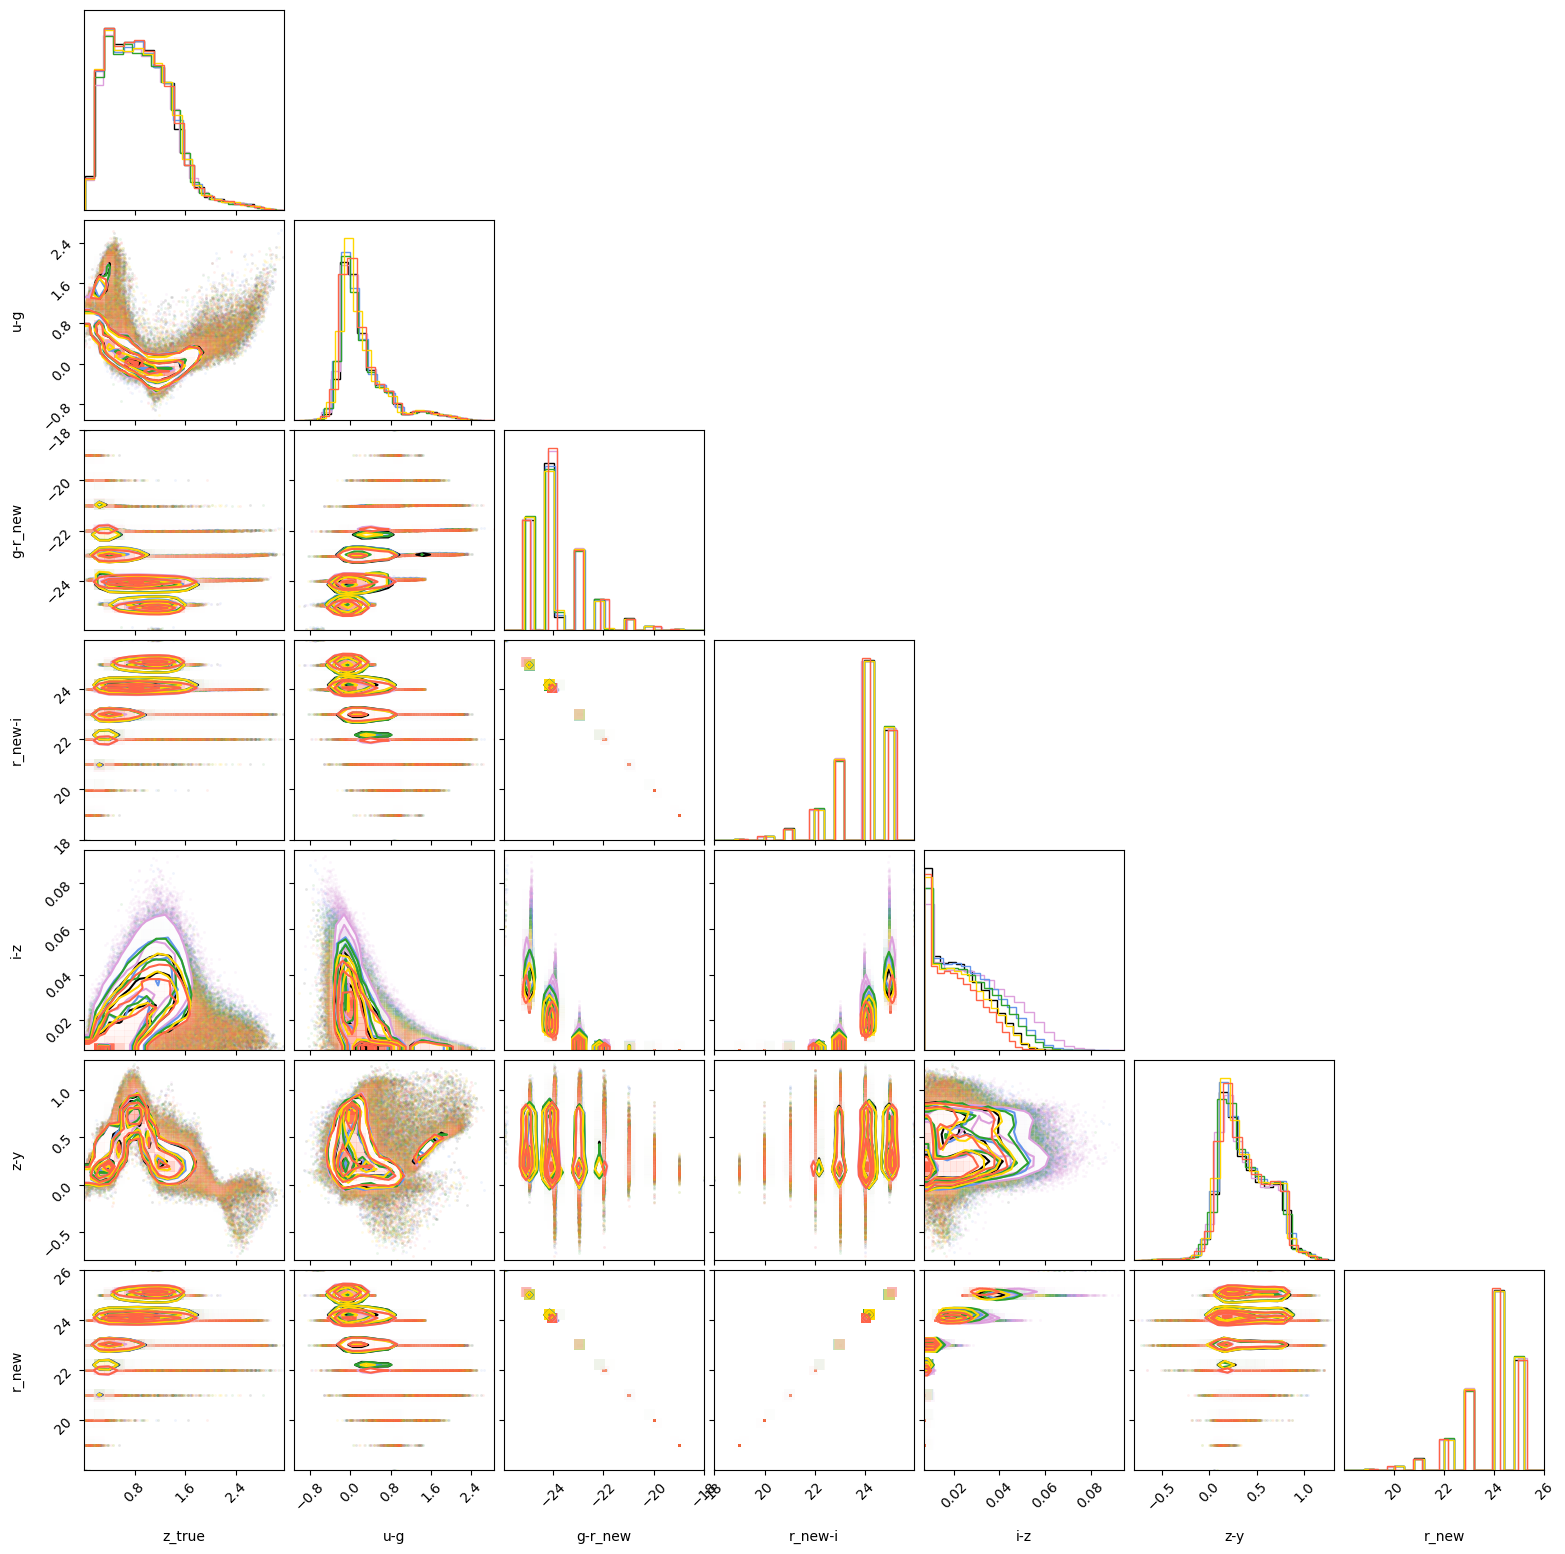

In [31]:
labels = ['z_true', 'u-g', 'g-r_new', 'r_new-i', 'i-z', 'z-y', 'r_new']
def prep_for_corner(one_os):
  return np.array([phot_cats[one_os]['z_true'], phot_cats[one_os]['u-g'],
                   phot_cats[one_os]['g-r_new'], phot_cats[one_os]['r_new-i'],
                   phot_cats[one_os]['i-z'], phot_cats[one_os]['z-y'],
                   phot_cats[one_os]['r_new']]).T
fig = corner.corner(prep_for_corner(available_os[0]), labels=labels, fontsize=14)
for which_os in available_os[1:]:
  corner.corner(prep_for_corner(which_os), fig=fig, color=os_colors[which_os], fontsize=14)

We now need to define the notion of a 'conditional column', that is, p(z | X), where X are the photometric columns and z is the conditional column that is conditioned on the photometry.

In [51]:
drop_cols = ['ID', 'u', 'g', 'y', 'i', 'z', 'r', 'g-r', 'r-i', 'r_new', 'z_true',
        'err_u', 'err_g', 'err_r', 'err_i', 'err_z', 'err_y',
        'err_u-g', 'err_g-r', 'err_r-i', 'err_i-z', 'err_z-y']


In [ ]:
print(phot_cats['10_92_y10'][0])

   ID     z_true      u        g         r        i       z        y       err_u    err_g     err_r    err_i     err_z    err_y     u-g      g-r       r-i      i-z     z-y    err_u-g  err_g-r  err_r-i  err_i-z  err_z-y  r_new  g-r_new   r_new-i 
------- --------- --------- -------- --------- ------- -------- -------- --------- -------- --------- -------- --------- -------- -------- -------- --------- ------- -------- -------- -------- -------- -------- -------- ----- ---------- --------
2103977 1.6824036 23.737208 0.041375 23.553011 0.01405 23.85648 0.014997 23.610221 0.019572 23.366287 0.027122 23.285724 0.046471 0.184198 0.043695 -0.303469 0.02055 0.246259 0.024658 0.243934 0.033447 0.080563 0.053807  24.0 -23.958625 23.98595


**Skip the next two cells if loading pre-trained flows**

We now loop through the observing strategies and define a dictionary containing ensembles of normalizing flow objects that will be trained on the simulated data.

In [52]:
 # mins = [0, 20, -5, -5, -5, -5, -5]
 # maxs = [6, 30, 5, 5, 5, 5, 5]

 # the data column is the one that is sampled and transformed by the flow
 data_columns = ["r_new"]

 # all_cond_cols = {}
 ensembles = dict()
 K = 16

 for which_os in available_os:#catalogs.keys():
   # the conditional columns are the columns that the flow is conditioned on
   conditional_columns = phot_cats[which_os].to_pandas().drop(drop_cols, axis = 1)
   # all_cond_cols[os] = conditional_columns
   print((conditional_columns))
   ndcol = len(data_columns)
   ncond = len(conditional_columns)
   ndim = ndcol+ncond

 # first I create a bijector chain
 # the first bijection is a standard scaler - but I'm not actually using it for standard scaling,
 # the second bijection is a NeuralSplineCoupling. I told it to expect 6 conditions,
 #     which will be the r mag and the galaxy colors


   bijector = Chain(
     StandardScaler(np.atleast_1d(1.6), np.atleast_1d(0.32)),
     NeuralSplineCoupling(B=5, n_conditions=5, K=K)
   )

 # I set the latent distribution to a Uniform over (-5, 5)
 # this range was chosen to match the NeuralSplineCoupling domain
 # I chose a Uniform since all of the redshifts are drawn from a compact domain

   latent = Uniform(input_dim=ndcol, B=7) # this has changed.

   # info = f"Models z_true conditioned on galaxy colors and r mag from os {os}. K = 16"

   flowEns2 = FlowEnsemble(data_columns = data_columns,
                            conditional_columns = conditional_columns,
                            bijector = bijector,
                            latent = latent,
                            # info = info,
                            N = 3
                             )
   ensembles[which_os] = flowEns2

            u-g       i-z       z-y    g-r_new    r_new-i
0      0.317131  0.007071  0.292791 -20.993583  20.995000
1      0.141072  0.009380  0.255765 -22.979592  22.992064
2      0.058468  0.024783  0.445597 -23.937437  23.978182
3     -0.046987  0.019194  0.408115 -23.963614  23.984778
4      0.092545  0.015823  0.405813 -23.964257  23.987283
...         ...       ...       ...        ...        ...
49995 -0.145749  0.028257  0.292012 -23.949633  23.978176
49996  0.370309  0.007075  0.478239 -21.986023  21.994995
49997 -0.060489  0.033544  0.570199 -24.935095  24.973067
49998  0.582205  0.016179  1.094741 -23.931886  23.984813
49999  0.169316  0.010449  0.890017 -22.976648  22.991013

[50000 rows x 5 columns]
            u-g       i-z       z-y    g-r_new    r_new-i
0      2.054772  0.007071  0.587080 -20.979004  20.995000
1     -0.132423  0.058995  0.448716 -24.876782  24.951683
2     -0.097031  0.039549  0.676993 -24.913431  24.967666
3     -0.315357  0.020691  0.285992 -23.966353

This next cell trains the model for 150 epochs and saves the output.

In [53]:
print(available_os)

['1_4_y10', '4_38_y10', '10_92_y10', '4_34_y10', '7_61_y10', '9_86_y10']


In [54]:
 # tav_train, tav_test = {}, {}
 # available_os = ['weather_1.2_v1.4_10yrs']
 prepend = 'drive/MyDrive/TLM Discrete r Old Data 3rd Run/'

 for which_os in available_os[:]:#:
     ens  = ensembles[which_os]
     # get the data and make a train and test set
     cat = phot_cats[which_os].to_pandas()
     # cat_train = cat.sample(frac = 0.99)
     # cat_test = cat.drop(cat_train.index)
     cat_train = cat
     print(which_os)
     # train the flow on the given learning rate schedule
     loss = ens.train(cat_train,#conditional_columns],
                                convolve_errs=False,
                        epochs = 150, verbose=True)
     # loss2 = ens.train(cat_train, convolve_errs=True,
     #                    epochs = 30, seed = 312)
     # loss3 = ens.train(cat_train, convolve_errs=True,
     #                    epochs = 30, seed = 231)

     # losses = {fname : # for each flow trained in the ensemble...
     #               [float(loss) # save the list of training losses
     #                for lossDict in [loss1]#, loss2, loss3]
     #                for loss in lossDict[fname]]
     #           for fname in loss1}

     # print the train and test loss
     train_loss = -np.mean(ens.log_prob(cat_train))
     # test_loss = -np.mean(ens.log_prob(cat_test))
     print(which_os, train_loss)#, test_loss)
     # post_trained[os] = ens
     # save the ensemble
     ens.save(prepend+f"3_pzflow_ensemble_for_{which_os}.pkl")
     # and the losses
     with open(prepend+f"3_losses_for_{which_os}.pkl", "wb") as file:
         pickle.dump({"losses": loss,
                      "train loss": train_loss,
                     #  "test loss": test_loss,
                      "train_ids": cat_train.index},
                     file)

     # mutual_information_lower_bound_train = ens.log_prob(cat_train, returnEnsemble=True)
     # mutual_information_lower_bound_test = ens.log_prob(cat_test, returnEnsemble=True)
     # tav_train[os] = mutual_information_lower_bound_train
     # tav_test[os] = mutual_information_lower_bound_test


1_4_y10
Flow 0
Training 150 epochs 
Loss:
(0) inf
(1) inf
Training stopping after epoch 1 because training loss diverged.
Flow 1
Training 150 epochs 
Loss:
(0) inf
(1) inf
Training stopping after epoch 1 because training loss diverged.
Flow 2
Training 150 epochs 
Loss:
(0) inf
(1) inf
Training stopping after epoch 1 because training loss diverged.
1_4_y10 inf
4_38_y10
Flow 0
Training 150 epochs 
Loss:
(0) inf
(1) inf
Training stopping after epoch 1 because training loss diverged.
Flow 1
Training 150 epochs 
Loss:
(0) inf
(1) inf
Training stopping after epoch 1 because training loss diverged.
Flow 2
Training 150 epochs 
Loss:
(0) inf
(1) inf
Training stopping after epoch 1 because training loss diverged.
4_38_y10 inf
10_92_y10
Flow 0
Training 150 epochs 
Loss:
(0) inf
(1) inf
Training stopping after epoch 1 because training loss diverged.
Flow 1
Training 150 epochs 
Loss:
(0) inf
(1) inf
Training stopping after epoch 1 because training loss diverged.
Flow 2
Training 150 epochs 
Loss:
(0

# Now, we open the saved flows by looping through a dictionary defining a mapping between observing strategy and each flow ensemble object. And we visualize the losses to confirm convergence.

In [ ]:
# change to the Directory where the flows are saved.
# cd /content/drive/MyDrive/Research/RubinPz/trained_flows_losses_May
# prepend = 'drive/MyDrive/TLM Discrete r Old Data 3rd Run/'

In [32]:
phot_cats_pandas = phot_cats[available_os[0]].to_pandas()

In [ ]:
grids = jnp.linspace(0, 5, 100)
pdfs = ensembles[available_os[0]].posterior(phot_cats_pandas, column='r_new', grid = grids)

In [ ]:
# First 8 r_new posterior plots plotted separately

for i in range(8):
  plt.plot(grids, pdfs[i], label="Redshift posterior")

  r = phot_cats_pandas["r_new"][i]
  plt.axvline(r, c="C3", label="True redshift")

  xlabel="redshift"

  plt.show()

In [ ]:
# First 3 r_new posterior plots plotted together

for i in range(3):
  plt.plot(grids, pdfs[i], label="Redshift posterior")

  ztrue = phot_cats_pandas["r_new"][i]
  plt.axvline(ztrue, c="C3", label="True redshift")

  xlabel="redshift"

plt.show()

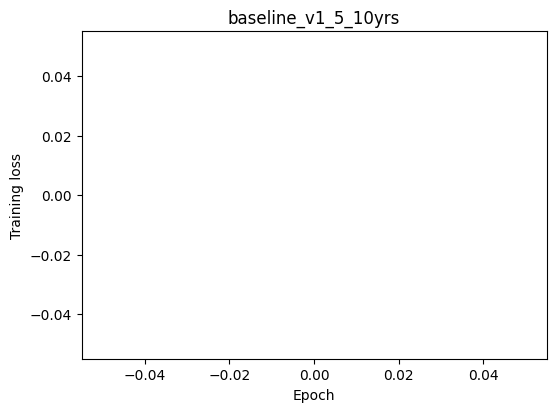

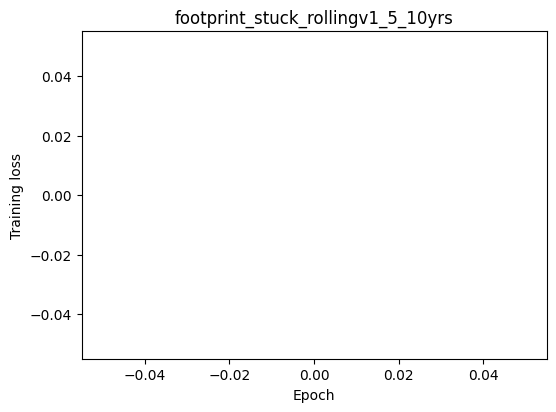

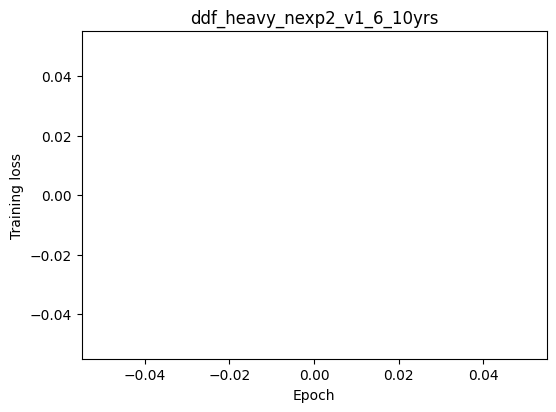

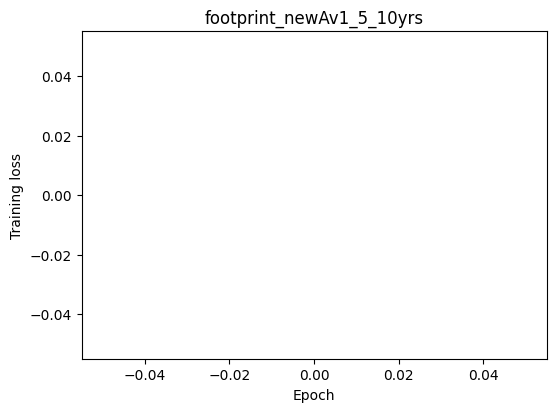

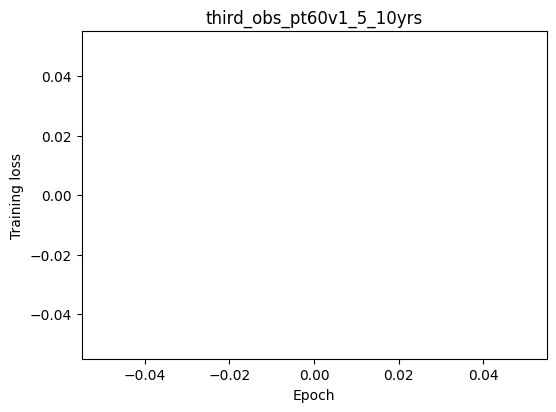

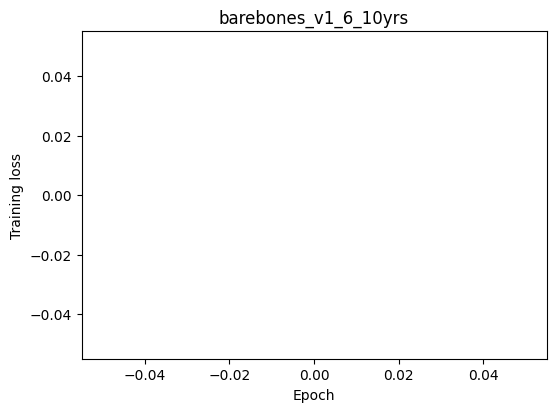

{'1_4_y10': [<pzflow.flowEnsemble.FlowEnsemble at 0x78b26d7a5c30>],
 '4_38_y10': [<pzflow.flowEnsemble.FlowEnsemble at 0x78b25a0cd660>],
 '10_92_y10': [<pzflow.flowEnsemble.FlowEnsemble at 0x78b25a105780>],
 '4_34_y10': [<pzflow.flowEnsemble.FlowEnsemble at 0x78b26d62e290>],
 '7_61_y10': [<pzflow.flowEnsemble.FlowEnsemble at 0x78b26d24b610>],
 '9_86_y10': [<pzflow.flowEnsemble.FlowEnsemble at 0x78b26d26fe50>]}

In [55]:
# why no Flow 0 in losses? but it's present in the flows which matters more

flows = {}
for which_os in available_os:
  flows[which_os] = [FlowEnsemble(file=prepend+f"3_pzflow_ensemble_for_{which_os}.pkl" )]
  with open(prepend+f'3_losses_for_'+which_os+'.pkl', "rb") as file:
    losses = pickle.load(file)["losses"]
    # print(np.shape(losses))
  fig, ax = plt.subplots(figsize=(6, 4.25), dpi=100)
  ax.set_title(os_names[which_os])
  for k in losses.keys():
    ax.plot(losses[k], alpha=0.5)#, label = str(i))
    # ax.plot([], c=os_colors['10_92_y10'], label=i)

#  ax.legend()
  ax.set(xlabel="Epoch", ylabel="Training loss")
  plt.show()

# just_tav = {}
# for os in available_os:
#   just_tav[os] = post_trained[os].log_prob(catalogs[os])

flows

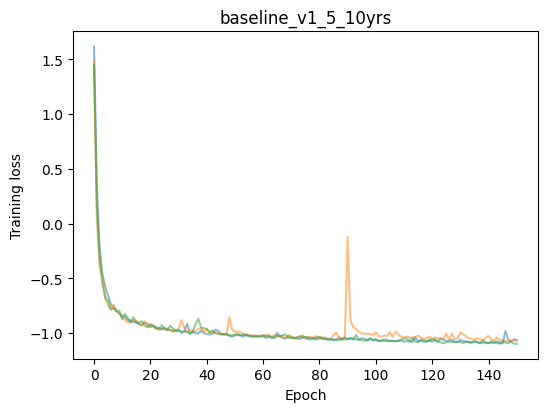

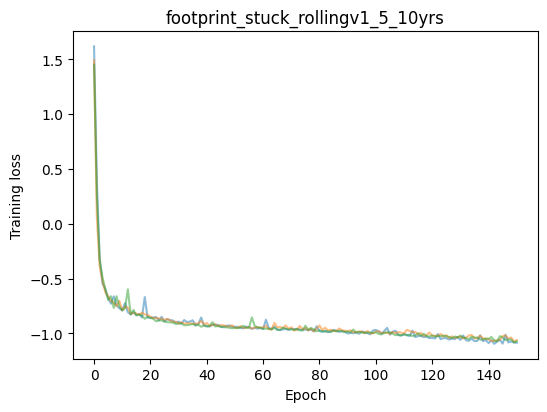

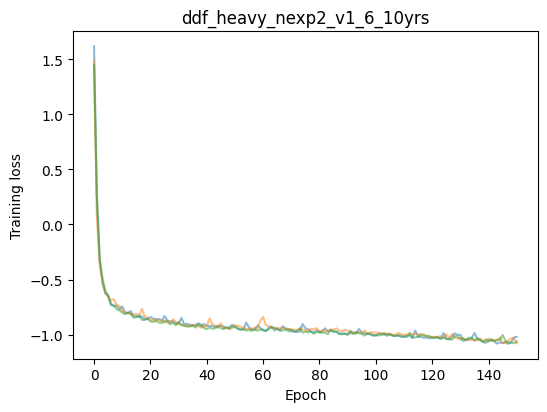

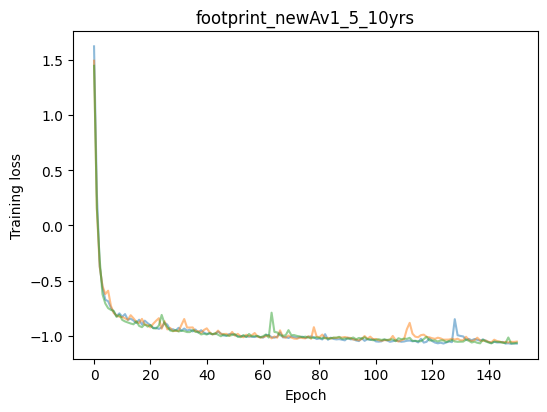

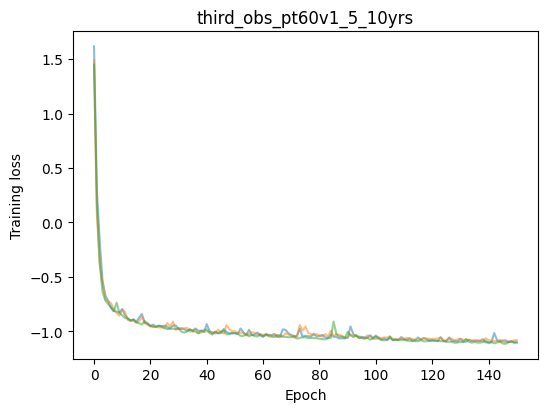

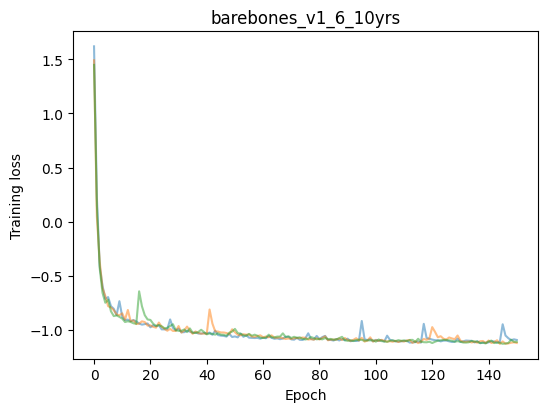

{'1_4_y10': [<pzflow.flowEnsemble.FlowEnsemble at 0x7cceb09055a0>],
 '4_38_y10': [<pzflow.flowEnsemble.FlowEnsemble at 0x7ccebe143610>],
 '10_92_y10': [<pzflow.flowEnsemble.FlowEnsemble at 0x7cceb1bcd5d0>],
 '4_34_y10': [<pzflow.flowEnsemble.FlowEnsemble at 0x7ccec1a44c70>],
 '7_61_y10': [<pzflow.flowEnsemble.FlowEnsemble at 0x7ccec3a71690>],
 '9_86_y10': [<pzflow.flowEnsemble.FlowEnsemble at 0x7ccebe183010>]}

In [ ]:
prepend2 = 'drive/MyDrive/TLM Discrete r Old Data 2nd Run/'

flows = {}
for which_os in available_os:
  flows[which_os] = [FlowEnsemble(file=prepend2+f"pzflow_ensemble_for_{which_os}.pkl" )]
  with open(prepend2+f'losses_for_'+which_os+'.pkl', "rb") as file:
    losses = pickle.load(file)["losses"]
    # print(np.shape(losses))
  fig, ax = plt.subplots(figsize=(6, 4.25), dpi=100)
  ax.set_title(os_names[which_os])
  for k in losses.keys():
    ax.plot(losses[k], alpha=0.5)#, label = str(i))
    # ax.plot([], c=os_colors['10_92_y10'], label=i)

#  ax.legend()
  ax.set(xlabel="Epoch", ylabel="Training loss")
  plt.show()

# just_tav = {}
# for os in available_os:
#   just_tav[os] = post_trained[os].log_prob(catalogs[os])

flows

In [ ]:
print(flows['9_86_y10'])
print(type(ensembles['9_86_y10']))
print(type(phot_cats['9_86_y10']['r_new']))
# print(phot_cats['9_86_y10']['r_new'])

<class 'pzflow.flowEnsemble.FlowEnsemble'>
<class 'astropy.table.column.Column'>


In [48]:
 # To plot p(z|x_phot)

drop_cols = ['ID', 'z_true', 'u', 'g', 'i','y', 'z','r', 'g-r', 'r-i', 'r_new',
        'err_u', 'err_g', 'err_r', 'err_i', 'err_z', 'err_y',
        'err_u-g', 'err_g-r', 'err_r-i', 'err_i-z', 'err_z-y']

# mins = [0, 20, -5, -5, -5, -5, -5]
# maxs = [6, 30, 5, 5, 5, 5, 5]

# the data column is the one that is sampled and transformed by the flow
data_columns = ["z_true"]

# all_cond_cols = {}
ensembles = dict()
K = 16

for which_os in available_os:#catalogs.keys():
  # the conditional columns are the columns that the flow is conditioned on
  conditional_columns = phot_cats[which_os].to_pandas().drop(drop_cols, axis = 1)
  # all_cond_cols[os] = conditional_columns
  # print((conditional_columns))
  ndcol = len(data_columns)
  ncond = len(conditional_columns)
  ndim = ndcol+ncond

 # first I create a bijector chain
 # the first bijection is a standard scaler - but I'm not actually using it for standard scaling,
 # the second bijection is a NeuralSplineCoupling. I told it to expect 6 conditions,
 #     which will be the r mag and the galaxy colors


  bijector = Chain(
    StandardScaler(np.atleast_1d(1.6), np.atleast_1d(0.32)),
    NeuralSplineCoupling(B=5, n_conditions=5, K=K)
  )

 # I set the latent distribution to a Uniform over (-5, 5)
 # this range was chosen to match the NeuralSplineCoupling domain
 # I chose a Uniform since all of the redshifts are drawn from a compact domain

  latent = Uniform(input_dim=ndcol, B=7) # this has changed.

   # info = f"Models z_true conditioned on galaxy colors and r mag from os {os}. K = 16"

  flowEns2 = FlowEnsemble(data_columns = data_columns,
                          conditional_columns = conditional_columns,
                          bijector = bijector,
                          latent = latent,
                          # info = info,
                          N = 3
                            )
  ensembles[which_os] = flowEns2

In [49]:
grids = jnp.linspace(0, 5, 100)
pdfs = ensembles[available_os[0]].posterior(phot_cats_pandas, column='z_true', grid = grids)

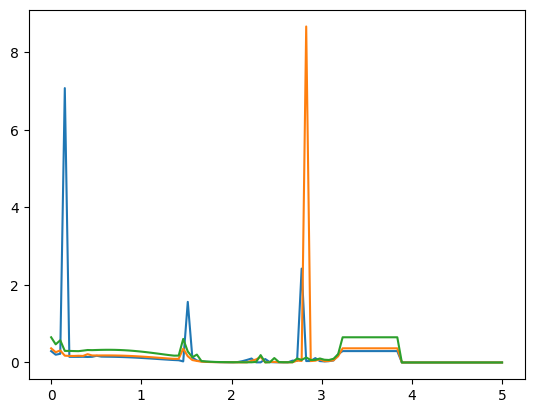

In [50]:
 # Plot of p(z|x_phot)

plt.show()
for i in range(3):
  plt.plot(grids, pdfs[i], label="Redshift posterior")

  ztrue = phot_cats_pandas["z_true"][i]
  #plt.axvline(ztrue, c="C3", label="True redshift")

  #xlabel="redshift"

plt.show()

In [ ]:
# fig, ax = plt.subplots(figsize=(6, 4.25), dpi=100)


# with open(f"losses_for_10_92_y10.pkl", "rb") as file:
#     losses = pickle.load(file)["losses"]

# for i,ls in enumerate(losses.values()):
#     ax.plot(ls, alpha=0.5, label = str(i))
#     # ax.plot([], c=os_colors['10_92_y10'], label=i)

# ax.legend()
# ax.set(xlabel="Epoch", ylabel="Training loss")
# plt.show()

# Next, we compute the per galaxy log probability and aggregate those into TheLastMetric. This requires us to loop over the observing strategies, each of which is stored in flows[which_os].

In [ ]:
 #all_logp = {}
 #for which_os in available_os:
 #  all_logp[which_os] = np.stack([f.log_prob(phot_cats[which_os].to_pandas(), returnEnsemble=True)
 #                                 for f in flows[which_os] ], axis=0)

In [ ]:
# zbins = np.linspace(0, 3, 32)
# avgtav = {}
# errtav = {}
# for which_os in available_os:
#   plotran = np.empty_like(zbins)
#   ploterr = np.empty_like(zbins)
#   if 'logprob' not in phot_cats[which_os].columns.values():
#     phot_cats[which_os]['logprob'] = all_logp[which_os]
#   for i, zmin in enumerate(zbins[:-1]):
#     zmax = zbins[i+1]
#     subset = phot_cats[which_os][(phot_cats[which_os]['z_true'] >= zmin) & (phot_cats[which_os]['z_true'] < zmax)]
#     # print((zmin, len(subset), zmax))
#     vals = subset['logprob']
#     mean = np.mean(vals)
#     std = np.std(vals)
#     plotran[i] = mean
#     ploterr[i] = std
#   avgtav[os] = plotran
#   errtav[os] = ploterr



In [ ]:
 zbins = np.linspace(0, 3, 32)
 avgtav = {}
 errtav = {}
 which_os = available_os[0]
 plotran = np.empty_like(zbins)
 ploterr = np.empty_like(zbins)
 if 'logprob' not in phot_cats[which_os].columns: #.values():
   phot_cats[which_os]['logprob'] = all_logp[which_os]
 for i, zmin in enumerate(zbins[:-1]):
   zmax = zbins[i+1]
   subset = phot_cats[which_os][(phot_cats[which_os]['r_new'] >= zmin) & (phot_cats[which_os]['z_t'] < zmax)]
     # print((zmin, len(subset), zmax))
   vals = subset['logprob']
   mean = np.mean(vals)
   std = np.std(vals)
   plotran[i] = mean
   ploterr[i] = std
 avgtav[which_os] = plotran
 errtav[which_os] = ploterr

In [ ]:
# for which_os in available_os:
#   plt.errorbar(zbins, avgtav[which_os], errtav[which_os], label=which_os, alpha=0.5)
# plt.legend()
# plt.xlabel('z_true')
# plt.ylabel(chr(0x05ea))

In [ ]:
# def compute_last_metric(flow, photometry, redshift,
#                         entropy_nbins=120,
#                         entropy_range=[0.,3.]):
#   """ Computes the last metric given a trained flow and corresponding photometry
#   and redshift astropy tables
#   """
#   cat = photometry.to_pandas().merge(redshift.to_pandas())

#   # Computing the entropy H(z)
#   pz = scipy.stats.rv_histogram(np.histogram(cat['z_true'], bins=entropy_nbins,
#                                 range=entropy_range))
#   entropy = pz.entropy()

#   # Computing lower bound
#   mutual_information_lower_bound = flow.log_prob(cat) + entropy

#   return mutual_information_lower_bound

In [ ]:
n=101
b = sps.mstats.mquantiles(z_cats_no_nan[which_os]['z_true'], np.linspace(0,1,n, endpoint=True))
# print(len(z_cats_no_nan[which_os]['z_true']))
# print(b)

b_centers = 0.5*(b[1:] + b[:-1])
db = b[1:] - b[:-1]

In [ ]:
# import scipy.stats as sps

# dictionary to hold all the MILB
all_tlm = {}
all_milb = {}
all_ent = {}

for os in available_os:
    # print(os_names[os])
    # load the photometric catalog for this os
    cat = phot_cats[os].to_pandas().merge(z_cats[os].to_pandas())

  # Computing the entropy H(z)
    pz = sps.rv_histogram(np.histogram(phot_cats[os]['z_true'], bins=b))
    entropy = pz.entropy()
    # just checking that this isn't discrete entropy and that binning doesn't need to match anything else
    # testent = sum(-1 * pz.logpdf(b_centers) * pz.pdf(b_centers) * db)
    # print(entropy - testent)
    all_ent[os] = entropy

  # Computing lower bound
    # all_milb = []
    # print(len(flows[os]))
    # for i in range(10):
    milb = flows[os][0].log_prob(cat, returnEnsemble=True, err_samples=10)# + entropy
    # print(milb)
    all_milb[os] = np.array(milb)
    # print(np.shape(all_milb[os]))
    all_tlm[os] = milb.mean(axis=0) + entropy
    # print(all_tlm[os])
    # all_os_milb[os] = np.array(all_milb)
    # print((all_milb[os].shape, all_tlm[os].shape))

#TODO: actually need to add these errors in quadrature
    print((os_names[os], np.mean(all_tlm[os]), np.std(all_tlm[os])))

# all_os_milb = all_milb

with open(prepend+'stats.pkl', 'wb') as statfile:
  pickle.dump({'tlm': all_tlm, 'milb': all_milb, 'ent': all_ent}, statfile)

In [ ]:
with open(prepend+'stats.pkl', 'rb') as statfile:
  statdict = pickle.load(statfile)

In [ ]:
all_tlm = statdict['tlm']
all_milb = statdict['milb']
all_ent = statdict['ent']

In [ ]:
all_milb[os].shape

In [ ]:
for os in available_os:
  plt.hist(all_tlm[os].mean(axis=1), color=os_colors[os])
  plt.hist(all_milb[os].mean(axis=1), color=os_colors[os])

In [ ]:
# for os in available_os:
#   all_tlm_err[os] = np.sqrt(np.sum(all_milb[os].var(axis=0)))

In [ ]:
# # Computing metric for each observing strategy
# all_tlm = {}
# for which_os in available_os:
#   all_tlm[which_os] = np.stack([(compute_last_metric(f,
#                                           phot_cats[which_os],
#                                           z_cats[which_os], entropy_nbins=60)) for f in flows[which_os] ], axis=0)
#   print((os_names[which_os], np.mean(all_tlm[which_os]), np.std(np.mean(all_tlm[which_os], axis=1))))



# Histogram of TLM values for each observing strategy

In [ ]:
overall_tavbins = np.linspace(-5, 5, 100)

for os in available_os:
  # bt = sps.mstats.mquantiles(all_tlm[os].flatten(), np.linspace(0,1,n, endpoint=True))
  # print(all_os_milb[os][0].shape)
  plt.hist(all_milb[os].flatten(), density=True, alpha=0.25,
           label=os_names[os], color=os_colors[os],
           bins=overall_tavbins)
plt.legend()
# plt.xlim(-5,4)
plt.xlabel(r'$\log q_{\varphi} (z | x_{phot})$', fontsize=12)#r'$\mathbb{E}_{z, x_{phot}} \left[ q_\theta(z | x_{phot}) \right]$')
plt.yticks([])
# plt.savefig(prepend+'all_combos_histogram.pdf')
plt.ylabel(r'probability density $p(\log q_{\varphi} (z | x_{phot}))$', fontsize=12)

NameError: name 'all_milb' is not defined

In [ ]:
tavbins = np.linspace(2.875, 3.15, 300)

In [ ]:
all_mu = {}
all_sig = {}

plt.figure(figsize=(7,5))
for which_os in available_os:
  # plt.hist(all_tlm[which_os],#np.mean([(all_logp[which_os].T[j]) for j in range(10)], axis=1),
  #          bins=tavbins, alpha=0.6,
  #      color=os_colors[which_os], label=os_names[which_os])

  # for j in range(10):
  #   plt.axvline(np.mean(all_logp[which_os].T[j]), alpha=0.6,
  #      color=os_colors[which_os])
  mu = np.mean(all_tlm[which_os])
  all_mu[os] = mu
  sig = np.std(all_tlm[which_os])
  all_sig[os] = sig
  plt.axvline(mu, linewidth=2, color=os_colors[which_os], label=os_names[which_os])
  plt.vlines(all_tlm[which_os], 0, 2.5, color=os_colors[which_os], linewidth=1)
  plt.fill_between(tavbins, sps.norm(mu, sig).pdf(tavbins),
                   alpha=0.3, color=os_colors[which_os])
plt.legend(ncol=2, fontsize='small')
plt.xlabel(chr(0x05ea), fontsize=16)
plt.ylim(0, 40)
plt.yticks([])
plt.ylabel(r'probability density $p($'+chr(0x05ea)+'$)$', fontsize=14)
# plt.savefig('metrics.pdf', bbox_inches = 'tight', pad_inches = 0 )

## Comparison to traditional metrics pf photo-z estimates

In [ ]:
def cmnn_bias(which_os):
    bias = (z_cats[which_os]['z_phot'] - z_cats[which_os]['z_true']) / (1 + z_cats[which_os]['z_phot'])
    return np.mean(bias)

def cmnn_stdd(which_os):
    stdd = sps.iqr((z_cats[which_os]['z_phot'] - z_cats[which_os]['z_true']) / (1 + z_cats[which_os]['z_phot']), scale='normal')
    return stdd#np.sqrt(np.mean(stdd))

def cmnn_out(which_os):
    stdd = cmnn_stdd(which_os)
    outs = z_cats[which_os][np.abs(z_cats[which_os]['z_phot'] - z_cats[which_os]['z_true']) >= 3.*stdd * (1 + z_cats[which_os]['z_phot'])]
    return len(outs) / len(z_cats[which_os])



all_mets = {}
tlm_over_trainings = {}
std_tlm_over_trainings = {}
for which_os in available_os:
    all_mets[which_os] = {}
    all_mets[which_os]['CMNN bias'] = cmnn_bias(which_os)
    all_mets[which_os]['CMNN scatter'] = cmnn_stdd(which_os)
    all_mets[which_os]['CMNN outliers'] = cmnn_out(which_os)
#     all_mets[which_os]['TLM mean'] = np.mean(all_milb[which_os].flatten())
#     all_mets[which_os]['TLM stdd'] = np.std(all_milb[which_os].flatten())
#     for key in ['CMNN bias', 'CMNN scatter', 'CMNN outliers']:#, 'TLM mean']:#, 'TLM stdd']:
#         extrema[key].append(all_mets[which_os][key])
    tlm_over_trainings[os_names[which_os]] = np.mean(all_tlm[which_os])
    std_tlm_over_trainings[os_names[which_os]] = np.std(all_tlm[which_os])
#     print((os_names[which_os], all_mets[which_os]))



NameError: name 'z_cats' is not defined

In [ ]:


fig, axs = plt.subplots(2, 1, figsize=(5, 7.5), sharex=True)
# x = [tlm_over_trainings[os_names[which_os]] for which_os in available_os]
# xerr = [std_tlm_over_trainings[os_names[which_os]] for which_os in available_os]
axs[-1].set_xlabel(r'$\langle$'+chr(0x05ea)+r'$\rangle$', fontsize=14)
for which_os in available_os:
    x = tlm_over_trainings[os_names[which_os]]
    xerr = std_tlm_over_trainings[os_names[which_os]]
    for i, met in enumerate(['CMNN scatter', 'CMNN outliers']):
        y = all_mets[which_os][met]
        axs[i].errorbar(x, y, xerr=xerr, capsize=5,
                        color=os_colors[which_os], fmt='o')
for i, met in enumerate(['CMNN scatter', 'CMNN outliers']):
    axs[i].set_ylabel(met, fontsize=14)
fig.tight_layout()
fig.subplots_adjust(hspace=0.0)



# And compute the average value of the last metric in redshift bins.

In [ ]:
# all_logp = {}
# for which_os in available_os:
#   all_logp[which_os] = np.stack([f.log_prob(phot_cats[which_os].to_pandas())
#                                  for f in flows[which_os] ], axis=0)

# from scipy import stats
nz=31
bz = sps.mstats.mquantiles(z_cats_no_nan[which_os]['z_true'], np.linspace(0, 1, nz, endpoint=True))
# print(len(z_cats_no_nan[which_os]['z_true']))

mis = {}

for which_os in available_os:
  inds = np.digitize(z_cats_no_nan[which_os]['z_true'], bz) -1

  print(len(inds))

  all_res = []
  for j in range(10):
    res = np.zeros(nz-1)
    for i in range(nz-1):
      # res[i] = np.mean( np.mean((all_logp[which_os].flatten()[inds == i])))
      res[i] = np.mean(all_milb[which_os].T[j][inds == i])
    all_res.append(res)
  mis[which_os] = np.array(all_res)


In [ ]:
bz_centers = 0.5*(bz[1:] + bz[:-1])

plt.figure(figsize=(6,5))
for which_os in available_os:
  for j in range(10):
    plt.plot(bz_centers, -mis[which_os][j], color=os_colors[which_os], alpha=0.25, linewidth=0.5)
  plt.plot(bz_centers, np.mean(-mis[which_os], axis=0), label=os_names[which_os], color=os_colors[which_os], alpha=0.75)
plt.legend()
plt.ylabel(r'$- \log q_{\varphi} (z | x_{phot})$', fontsize=14)
plt.xlabel('True redshift z', fontsize=14)
plt.xlim(0,3);
# TODO: fix y axis: this is -MILB, including entropy and as f(z)

In [ ]:
plt.figure(figsize=(6,5))
for which_os in available_os:
  sig = np.std(-mis[which_os], axis=0)
  # for j in range(10):
  #   plt.plot(b_centers, -mis[which_os][j], color=os_colors[which_os], alpha=0.25, linewidth=0.5)
  mu = np.mean(-mis[which_os], axis=0)
  plt.plot(bz_centers, mu, label=os_names[which_os], color=os_colors[which_os], alpha=0.75)
  plt.fill_between(bz_centers, mu - sig, mu + sig, color=os_colors[which_os], alpha=0.25)
plt.legend()
plt.ylabel(r'$- \log q_{\varphi} (z | x_{phot})$', fontsize=14)
plt.xlabel('True redshift z', fontsize=14)
plt.xlim(0,3);
# TODO: fix y axis: this is -MILB, including entropy and as f(z)

In [ ]:
# # all_logp = {}
# # for which_os in available_os:
# #   all_logp[which_os] = np.stack([f.log_prob(phot_cats[which_os].to_pandas())
# #                                  for f in flows[which_os] ], axis=0)

# from scipy import stats
# n=32
# b = stats.mstats.mquantiles(z_cats_no_nan[which_os]['z_true'], np.linspace(0,1,n, endpoint=True))
# print(len(z_cats_no_nan[which_os]['z_true']))

# var2 = {}

# for which_os in available_os:
#   inds = np.digitize(z_cats_no_nan[which_os]['z_true'], b) -1

#   print(len(inds))


#   vars = np.zeros(n-1)
#   for i in range(n-1):
#     # res[i] = np.mean( np.mean((all_logp[which_os].flatten()[inds == i])))
#     vars[i] = np.mean( np.var([(all_logp[which_os].T[j].flatten()[inds == i]) for j in range(10)]))

#   var2[which_os] = np.sqrt(vars)

# b_centers = 0.5*(b[1:] + b[:-1])

# plt.figure(figsize=(6,5))
# for i, which_os in enumerate(available_os):
#   plt.plot(b_centers, - mis[which_os], label=os_names[which_os], color=os_colors[which_os])
#   plt.fill_between(b_centers, - mis[which_os] - var2[which_os], - mis[which_os] + var2[which_os], color=os_colors[which_os], edgecolor=os_colors[which_os], alpha = 0.1)
# plt.legend()
# plt.ylabel(r'$- \log q_{\varphi} (z | x_{phot})$')
# plt.xlabel('True redshift z')
# plt.xlim(0,3);

# Same as before, with baseline scenario subtracted off.

In [ ]:
# for which_os in available_os:
#   plt.plot(b_centers, mis[which_os] - mis['1_4_y10'], label=os_names[which_os], color=os_colors[which_os])
# plt.legend(loc='upper right')
# plt.xlabel('$z$')
# plt.ylabel('$I(X ; Z) - I(X_{baseline} ; Z)$');
# plt.savefig('figure4.pdf')
# plt.ylim(-0.6,0.6)